In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pu_loss import PULoss, PULossWrapped, PURankingLoss
%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load Data

In [2]:
DATA_DIR = os.path.join("data", "UCI HAR Dataset")

In [3]:
features_path = os.path.join(DATA_DIR, "features.txt")
features = pd.read_csv(features_path, sep='\s+', header=None, names=['index', 'feature_name'])['feature_name'].tolist()

In [4]:
X_train = pd.read_csv(
    os.path.join(DATA_DIR, "train", "X_train.txt"),
    sep='\s+',
    header=None,
)
X_test = pd.read_csv(
    os.path.join(DATA_DIR, "test", "X_test.txt"),
    sep='\s+',
    header=None,
)

y_train = pd.read_csv(
    os.path.join(DATA_DIR, "train", "y_train.txt"),
    header=None
)[0]
y_test = pd.read_csv(
    os.path.join(DATA_DIR, "test", "y_test.txt"),
    header=None
)[0]

In [5]:
pd.set_option('display.max_columns', None)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,0.963396,-0.140840,0.115375,-0.985250,-0.981708,-0.877625,-0.985001,-0.984416,-0.894677,0.892055,-0.161265,0.124660,0.977436,-0.123213,0.056483,-0.375426,0.899469,-0.970905,-0.975510,-0.984325,-0.988849,-0.917743,-1.0,-1.0,0.113806,-0.590425,0.591146,-0.591773,0.592469,-0.745449,0.720862,-0.712372,0.711300,-0.995112,0.995675,-0.995668,0.991653,0.570222,0.439027,0.986913,0.077996,0.005001,-0.067831,-0.993519,-0.988360,-0.993575,-0.994488,-0.986207,-0.992818,-0.985180,-0.991994,-0.993119,0.989835,0.991957,0.990519,-0.993522,-0.999935,-0.999820,-0.999878,-0.994364,-0.986025,-0.989234,-0.819949,-0.793046,-0.888853,1.000000,-0.220747,0.636831,0.387644,0.241401,-0.052253,0.264177,0.373439,0.341778,-0.569791,0.265399,-0.477875,-0.385300,0.033644,-0.126511,-0.006101,-0.031365,0.107725,-0.985310,-0.976623,-0.992205,-0.984586,-0.976353,-0.992362,-0.867044,-0.933786,-0.747566,0.847308,0.914895,0.830841,-0.967184,-0.999578,-0.999354,-0.999763,-0.983438,-0.978614,-0.992966,0.082632,0.202268,-0.168757,0.096323,-0.274985,0.498644,-0.220317,1.000000,-0.972971,0.316655,0.375726,0.723399,-0.771112,0.690213,-0.331831,0.709584,0.134873,0.301099,-0.099167,-0.055517,-0.061986,-0.992111,-0.992519,-0.992055,-0.992165,-0.994942,-0.992619,-0.990156,-0.986743,-0.992042,0.994429,0.991756,0.989352,-0.994453,-0.999938,-0.999954,-0.999923,-0.992300,-0.996939,-0.992243,-0.589851,-0.688459,-0.572107,0.292376,-0.361998,0.405543,-0.039007,0.989284,-0.414560,0.391603,0.282251,0.927270,-0

In [6]:
activity_labels_df = pd.read_csv("data/UCI HAR Dataset/activity_labels.txt", sep='\s+', header=None, names=["id", "label"])
print(activity_labels_df)
labels = activity_labels_df["label"].to_list()

   id               label
0   1             WALKING
1   2    WALKING_UPSTAIRS
2   3  WALKING_DOWNSTAIRS
3   4             SITTING
4   5            STANDING
5   6              LAYING


In [7]:
y_train_np = y_train.to_numpy() - 1
y_test_np = y_test.to_numpy() - 1

In [8]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()


In [9]:
X_tr_tensor   = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_tr_tensor   = torch.tensor(y_train.values, dtype=torch.long) - 1
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long) - 1


In [10]:
X_tr_tensor = X_tr_tensor.view(X_tr_tensor.shape[0], 1, -1)
X_test_tensor = X_test_tensor.view(X_test_tensor.shape[0], 1, -1)
print(X_tr_tensor.shape, X_test_tensor.shape)

torch.Size([7352, 1, 561]) torch.Size([2947, 1, 561])


In [11]:
batch_size = 64

tr_dataset   = TensorDataset(X_tr_tensor, y_tr_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader   = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True) # train 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # test

In [12]:
def change_labels(y_train, y_test, fr, to):
    return np.where(y_train == fr, to, 1), np.where(y_test == fr, to, 1)

## PU-learnining 

### Transform Data to PU Problem

In [13]:
positive_class = 2
unlabeled_label = 0

y_train = np.where(y_train_np == positive_class, 1, unlabeled_label)
y_test = np.where(y_test_np == positive_class, 1, unlabeled_label)

In [17]:
positive_class = 2
unlabeled_label = 0

y_train_pu = np.where(y_train_np == positive_class, 1, unlabeled_label)
y_test_pu = np.where(y_test_np == positive_class, 1, unlabeled_label)
print(f"Positives before reduction, train: {y_train_pu[y_train_pu == 1].sum()}")
print(f"Positives before reduction, test: {y_test_pu[y_test_pu == 1].sum()}")


pos_idx_tr = np.where(y_train_pu == 1)[0]
pos_idx_tst = np.where(y_test_pu == 1)[0]
np.random.seed(0)
unmark_pos_tr = np.random.choice(pos_idx_tr, size=len(pos_idx_tr)//2, replace=False)
y_train_pu[unmark_pos_tr] = unlabeled_label
unmark_pos_tst = np.random.choice(pos_idx_tst, size=len(pos_idx_tst)//2, replace=False)
y_test_pu[unmark_pos_tst] = unlabeled_label
print(f"Positives after reduction, train: {y_train_pu[y_train_pu == 1].sum()}")
print(f"Positives after reduction, test: {y_test_pu[y_test_pu == 1].sum()}")


Positives before reduction, train: 986
Positives before reduction, test: 420
Positives after reduction, train: 493
Positives after reduction, test: 210


In [18]:
X_tr_tensor = X_tr_tensor.view(X_tr_tensor.shape[0], 1, -1)
X_test_tensor = X_test_tensor.view(X_test_tensor.shape[0], 1, -1)
print(X_tr_tensor.shape, X_test_tensor.shape)

torch.Size([7352, 1, 561]) torch.Size([2947, 1, 561])


In [19]:
batch_size = 64

In [30]:
y_tr_tensor_pu   = torch.tensor(y_train_pu, dtype=torch.long)
y_test_tensor_pu = torch.tensor(y_test_pu, dtype=torch.long)

tr_dataset_pu   = TensorDataset(X_tr_tensor, y_tr_tensor_pu)
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(tr_dataset_pu, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset_pu, batch_size=batch_size, shuffle=False)


In [21]:
# positive_prior = np.where(y_train_np == positive_class, 1, 0).mean()
# positive_prior

positive_prior = torch.tensor(
    np.where(y_train_np == positive_class, 1, 0).mean(),
    dtype=torch.float32
)
# positive_prior = torch.tensor((y_train_pu).mean(),
#                               dtype=torch.float32)

positive_prior = torch.tensor(
    np.where(y_train_pu == 1, 1, 0).mean(),
    dtype=torch.float32
)
positive_prior

tensor(0.0671)

## CNN + CE Loss

In [56]:
in_channel = X_tr_tensor.shape[1]
seq_length = X_tr_tensor.shape[2]
n_output = len(y_tr_tensor_pu.unique())-1
print(f'in_channel: {in_channel}, sequence_length: {seq_length}, n_output: {n_output}')
n_hidden = 64
num_epochs = 35
lr = 0.00001

in_channel: 1, sequence_length: 561, n_output: 1


In [25]:
from baseline import Conv_Net, train, LSTMNet
model = Conv_Net(in_channel, seq_length, n_hidden, n_output=2)
model = model.to(device)
print(model)

Conv_Net(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=17920, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=17920, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [120]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_test_pu)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_test_pu)
ce_weight = torch.tensor(weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=ce_weight)
ce_weight


tensor([0.5384, 7.0167], device='cuda:0')

In [92]:
model = train(model, criterion, train_loader, test_loader_pu, lr, num_epochs, device)

  0%|          | 0/115 [00:00<?, ?it/s]

100%|██████████| 115/115 [00:00<00:00, 154.17it/s]


Epoch [1/15], tr_loss: 0.30529 tr_acc: 0.93294 test_loss: 0.29578, test_acc: 0.92874


100%|██████████| 115/115 [00:00<00:00, 228.31it/s]


Epoch [2/15], tr_loss: 0.29184 tr_acc: 0.93294 test_loss: 0.29000, test_acc: 0.92874


100%|██████████| 115/115 [00:00<00:00, 232.14it/s]


Epoch [3/15], tr_loss: 0.28601 tr_acc: 0.93294 test_loss: 0.28508, test_acc: 0.92874


100%|██████████| 115/115 [00:00<00:00, 246.19it/s]


Epoch [4/15], tr_loss: 0.27875 tr_acc: 0.93294 test_loss: 0.28065, test_acc: 0.92874


100%|██████████| 115/115 [00:00<00:00, 255.94it/s]


Epoch [5/15], tr_loss: 0.27342 tr_acc: 0.93294 test_loss: 0.27595, test_acc: 0.92874


100%|██████████| 115/115 [00:00<00:00, 252.49it/s]


Epoch [6/15], tr_loss: 0.26923 tr_acc: 0.93294 test_loss: 0.27318, test_acc: 0.92874


100%|██████████| 115/115 [00:00<00:00, 254.10it/s]


Epoch [7/15], tr_loss: 0.26544 tr_acc: 0.93294 test_loss: 0.26963, test_acc: 0.92874


100%|██████████| 115/115 [00:00<00:00, 253.26it/s]


Epoch [8/15], tr_loss: 0.26201 tr_acc: 0.93349 test_loss: 0.26754, test_acc: 0.92942


100%|██████████| 115/115 [00:00<00:00, 243.97it/s]


Epoch [9/15], tr_loss: 0.25748 tr_acc: 0.93308 test_loss: 0.26403, test_acc: 0.92874


100%|██████████| 115/115 [00:00<00:00, 250.78it/s]


Epoch [10/15], tr_loss: 0.25502 tr_acc: 0.93267 test_loss: 0.26201, test_acc: 0.92467


100%|██████████| 115/115 [00:00<00:00, 256.80it/s]


Epoch [11/15], tr_loss: 0.25316 tr_acc: 0.93050 test_loss: 0.25936, test_acc: 0.92501


100%|██████████| 115/115 [00:00<00:00, 252.85it/s]


Epoch [12/15], tr_loss: 0.24922 tr_acc: 0.93199 test_loss: 0.25543, test_acc: 0.92671


100%|██████████| 115/115 [00:00<00:00, 231.30it/s]


Epoch [13/15], tr_loss: 0.24556 tr_acc: 0.93281 test_loss: 0.25356, test_acc: 0.92772


100%|██████████| 115/115 [00:00<00:00, 229.60it/s]


Epoch [14/15], tr_loss: 0.24262 tr_acc: 0.93498 test_loss: 0.25002, test_acc: 0.92806


100%|██████████| 115/115 [00:00<00:00, 234.10it/s]


Epoch [15/15], tr_loss: 0.24201 tr_acc: 0.93240 test_loss: 0.24990, test_acc: 0.92195


In [93]:
model.eval()
out_train = model(X_tr_tensor.to(device)).cpu()
preds_train = torch.max(out_train, 1)[1]

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

           0     1.0000    0.9211    0.9589      6859
           1     0.4768    1.0000    0.6457       493

    accuracy                         0.9264      7352
   macro avg     0.7384    0.9606    0.8023      7352
weighted avg     0.9649    0.9264    0.9379      7352

[[6318  541]
 [   0  493]]


In [94]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     1.0000    0.9925    0.9962      6366
           1     0.9536    1.0000    0.9762       986

    accuracy                         0.9935      7352
   macro avg     0.9768    0.9962    0.9862      7352
weighted avg     0.9938    0.9935    0.9935      7352

[[6318   48]
 [   0  986]]


In [96]:
out_test = model(X_test_tensor.to(device)).cpu()
preds_test = torch.max(out_test, 1)[1]

print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9968    0.9189    0.9563      2737
           1     0.4764    0.9619    0.6372       210

    accuracy                         0.9220      2947
   macro avg     0.7366    0.9404    0.7967      2947
weighted avg     0.9597    0.9220    0.9335      2947

[[2515  222]
 [   8  202]]


In [97]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9913    0.9897    0.9905      2527
           1     0.9387    0.9476    0.9431       420

    accuracy                         0.9837      2947
   macro avg     0.9650    0.9687    0.9668      2947
weighted avg     0.9838    0.9837    0.9837      2947

[[2501   26]
 [  22  398]]


In [98]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unmark_pos_tr] == y_train[unmark_pos_tr]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tr)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unmark_pos_tr)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unmark_pos_tst] == y_test[unmark_pos_tst]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tst)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unmark_pos_tst)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 493
In percentage: 1.0000
Test
Total number of positive sampels:420
Total number of unmarked positive sampels: 210
Number of unmarked samples correctly predicted as positive: 196
In percentage: 0.9333


In [100]:
torch.save(model, "models/har_cnn_crossentropy.pth")

## CNN + AsymLoss

In [116]:
n_hidden = 64
num_epochs = 20
lr = 0.0001
model = Conv_Net(in_channel, seq_length, n_hidden, n_output=2)
model = model.to(device)

In [107]:
from pu_loss import PUAsymLoss_CE
criterion = PUAsymLoss_CE(gamma=0.1)


In [108]:
model = train(model, criterion, train_loader, test_loader, lr, num_epochs, device)

100%|██████████| 115/115 [00:00<00:00, 300.62it/s]


Epoch [1/20], tr_loss: 0.58852 tr_acc: 0.84467 test_loss: 0.42968, test_acc: 0.86461


100%|██████████| 115/115 [00:00<00:00, 307.19it/s]


Epoch [2/20], tr_loss: 0.41105 tr_acc: 0.81134 test_loss: 0.37865, test_acc: 0.87445


100%|██████████| 115/115 [00:00<00:00, 306.93it/s]


Epoch [3/20], tr_loss: 0.35081 tr_acc: 0.84249 test_loss: 0.34129, test_acc: 0.89074


100%|██████████| 115/115 [00:00<00:00, 307.66it/s]


Epoch [4/20], tr_loss: 0.30986 tr_acc: 0.86738 test_loss: 0.31008, test_acc: 0.90363


100%|██████████| 115/115 [00:00<00:00, 306.41it/s]


Epoch [5/20], tr_loss: 0.27484 tr_acc: 0.88343 test_loss: 0.28303, test_acc: 0.90974


100%|██████████| 115/115 [00:00<00:00, 306.32it/s]


Epoch [6/20], tr_loss: 0.24587 tr_acc: 0.89459 test_loss: 0.25796, test_acc: 0.91551


100%|██████████| 115/115 [00:00<00:00, 305.40it/s]


Epoch [7/20], tr_loss: 0.22939 tr_acc: 0.89595 test_loss: 0.23910, test_acc: 0.91992


100%|██████████| 115/115 [00:00<00:00, 305.01it/s]


Epoch [8/20], tr_loss: 0.20449 tr_acc: 0.90520 test_loss: 0.22133, test_acc: 0.91992


100%|██████████| 115/115 [00:00<00:00, 305.08it/s]


Epoch [9/20], tr_loss: 0.18887 tr_acc: 0.90955 test_loss: 0.20825, test_acc: 0.92094


100%|██████████| 115/115 [00:00<00:00, 304.51it/s]


Epoch [10/20], tr_loss: 0.17760 tr_acc: 0.91104 test_loss: 0.19564, test_acc: 0.92060


100%|██████████| 115/115 [00:00<00:00, 303.99it/s]


Epoch [11/20], tr_loss: 0.15689 tr_acc: 0.91771 test_loss: 0.18631, test_acc: 0.92195


100%|██████████| 115/115 [00:00<00:00, 305.00it/s]


Epoch [12/20], tr_loss: 0.14985 tr_acc: 0.91825 test_loss: 0.17851, test_acc: 0.92162


100%|██████████| 115/115 [00:00<00:00, 304.21it/s]


Epoch [13/20], tr_loss: 0.14386 tr_acc: 0.91961 test_loss: 0.16726, test_acc: 0.91924


100%|██████████| 115/115 [00:00<00:00, 304.43it/s]


Epoch [14/20], tr_loss: 0.13174 tr_acc: 0.92179 test_loss: 0.16310, test_acc: 0.92128


100%|██████████| 115/115 [00:00<00:00, 305.27it/s]


Epoch [15/20], tr_loss: 0.13079 tr_acc: 0.92261 test_loss: 0.15653, test_acc: 0.92060


100%|██████████| 115/115 [00:00<00:00, 304.45it/s]


Epoch [16/20], tr_loss: 0.11949 tr_acc: 0.92519 test_loss: 0.15304, test_acc: 0.92094


100%|██████████| 115/115 [00:00<00:00, 304.74it/s]


Epoch [17/20], tr_loss: 0.11175 tr_acc: 0.92505 test_loss: 0.14782, test_acc: 0.91924


100%|██████████| 115/115 [00:00<00:00, 304.19it/s]


Epoch [18/20], tr_loss: 0.10753 tr_acc: 0.92777 test_loss: 0.14515, test_acc: 0.91619


100%|██████████| 115/115 [00:00<00:00, 304.22it/s]


Epoch [19/20], tr_loss: 0.10714 tr_acc: 0.92546 test_loss: 0.14306, test_acc: 0.91856


100%|██████████| 115/115 [00:00<00:00, 304.10it/s]


Epoch [20/20], tr_loss: 0.09715 tr_acc: 0.93036 test_loss: 0.14041, test_acc: 0.91992


In [121]:
model.load_state_dict(torch.load("models/har_cnn_asymloss_0.3.pth", weights_only=True))

<All keys matched successfully>

In [122]:
model.eval()
out_train = model(X_tr_tensor.to(device)).cpu()
preds_train = torch.max(out_train, 1)[1]

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

           0     1.0000    0.9079    0.9517      6859
           1     0.4382    1.0000    0.6094       493

    accuracy                         0.9140      7352
   macro avg     0.7191    0.9539    0.7805      7352
weighted avg     0.9623    0.9140    0.9287      7352

[[6227  632]
 [   0  493]]


In [123]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     1.0000    0.9782    0.9890      6366
           1     0.8764    1.0000    0.9342       986

    accuracy                         0.9811      7352
   macro avg     0.9382    0.9891    0.9616      7352
weighted avg     0.9834    0.9811    0.9816      7352

[[6227  139]
 [   0  986]]


In [124]:
out_test = model(X_test_tensor.to(device)).cpu()
preds_test = torch.max(out_test, 1)[1]

print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9976    0.9065    0.9498      2737
           1     0.4435    0.9714    0.6090       210

    accuracy                         0.9111      2947
   macro avg     0.7205    0.9389    0.7794      2947
weighted avg     0.9581    0.9111    0.9256      2947

[[2481  256]
 [   6  204]]


In [125]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9944    0.9786    0.9864      2527
           1     0.8826    0.9667    0.9227       420

    accuracy                         0.9769      2947
   macro avg     0.9385    0.9726    0.9546      2947
weighted avg     0.9784    0.9769    0.9774      2947

[[2473   54]
 [  14  406]]


In [126]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unmark_pos_tr] == y_train[unmark_pos_tr]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tr)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unmark_pos_tr)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unmark_pos_tst] == y_test[unmark_pos_tst]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tst)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unmark_pos_tst)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 493
In percentage: 1.0000
Test
Total number of positive sampels:420
Total number of unmarked positive sampels: 210
Number of unmarked samples correctly predicted as positive: 202
In percentage: 0.9619


In [115]:
torch.save(model.state_dict(), "models/har_cnn_asymloss_0.1.pth")

## CNN + PU Loss

In [104]:
y_train_pu_tensor = torch.tensor(np.where(y_train_pu == 1, 1, -1), dtype=torch.long)
y_test_pu_tensor = torch.tensor(np.where(y_test_pu == 1, 1, -1), dtype=torch.long)
batch_size = 64
print(X_tr_tensor.shape)
train_dataset = TensorDataset(X_tr_tensor, y_train_pu_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_pu_tensor)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([7352, 1, 561])


In [ ]:
y_train_pu, y_test_pu = change_labels(y_train_pu, y_test_pu, 0, -1)
y_train, y_test = change_labels(y_train, y_test, 0, -1)

In [ ]:
from pu_loss import PULoss
criterion = PULoss(prior=positive_prior)

In [ ]:
lr = 0.0005
model = Conv_Net(in_channel, seq_length, n_hidden, n_output=1)
model.load_state_dict(torch.load("models/har_cnn_pu.pth"))
model = model.to(device)

In [234]:
model = train(model, criterion, train_loader, test_loader, lr, num_epochs, device)

  0%|          | 0/115 [00:00<?, ?it/s]

/home/bebra/aic/har-pu-learning/pu_loss.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prior = torch.tensor(self.prior, device=inp.device)
100%|██████████| 115/115 [00:01<00:00, 104.93it/s]


Epoch [1/15], tr_loss: 0.13504 tr_acc: 0.92424 test_loss: 0.09210, test_acc: 0.92874


100%|██████████| 115/115 [00:00<00:00, 132.63it/s]


Epoch [2/15], tr_loss: 0.08872 tr_acc: 0.93172 test_loss: 0.08191, test_acc: 0.93146


100%|██████████| 115/115 [00:00<00:00, 139.47it/s]


Epoch [3/15], tr_loss: 0.07770 tr_acc: 0.93063 test_loss: 0.07921, test_acc: 0.93010


100%|██████████| 115/115 [00:00<00:00, 144.82it/s]


Epoch [4/15], tr_loss: 0.07385 tr_acc: 0.93131 test_loss: 0.07510, test_acc: 0.93485


100%|██████████| 115/115 [00:00<00:00, 138.14it/s]


Epoch [5/15], tr_loss: 0.07214 tr_acc: 0.93267 test_loss: 0.07008, test_acc: 0.93349


100%|██████████| 115/115 [00:00<00:00, 131.59it/s]


Epoch [6/15], tr_loss: 0.07112 tr_acc: 0.93471 test_loss: 0.06889, test_acc: 0.93247


100%|██████████| 115/115 [00:00<00:00, 135.60it/s]


Epoch [7/15], tr_loss: 0.06792 tr_acc: 0.93322 test_loss: 0.06739, test_acc: 0.93146


100%|██████████| 115/115 [00:00<00:00, 142.43it/s]


Epoch [8/15], tr_loss: 0.06507 tr_acc: 0.93607 test_loss: 0.06721, test_acc: 0.93078


100%|██████████| 115/115 [00:00<00:00, 140.28it/s]


Epoch [9/15], tr_loss: 0.05934 tr_acc: 0.93730 test_loss: 0.06565, test_acc: 0.93112


100%|██████████| 115/115 [00:00<00:00, 177.33it/s]


Epoch [10/15], tr_loss: 0.05720 tr_acc: 0.93784 test_loss: 0.06593, test_acc: 0.93180


100%|██████████| 115/115 [00:00<00:00, 188.50it/s]


Epoch [11/15], tr_loss: 0.05502 tr_acc: 0.94002 test_loss: 0.06563, test_acc: 0.93078


100%|██████████| 115/115 [00:00<00:00, 188.06it/s]


Epoch [12/15], tr_loss: 0.05346 tr_acc: 0.93702 test_loss: 0.06461, test_acc: 0.92976


100%|██████████| 115/115 [00:00<00:00, 189.76it/s]


Epoch [13/15], tr_loss: 0.05358 tr_acc: 0.93866 test_loss: 0.06659, test_acc: 0.93044


100%|██████████| 115/115 [00:00<00:00, 172.74it/s]


Epoch [14/15], tr_loss: 0.05227 tr_acc: 0.94328 test_loss: 0.06433, test_acc: 0.92942


100%|██████████| 115/115 [00:00<00:00, 183.96it/s]


Epoch [15/15], tr_loss: 0.05167 tr_acc: 0.94029 test_loss: 0.06532, test_acc: 0.92806


In [241]:
model.eval()
out_train = model(X_tr_tensor.to(device)).cpu()
preds_train = torch.where(
            out_train > 0,
            torch.tensor(1, device=out_train.device),
            torch.tensor(-1, device=out_train.device)
        ).view(-1)

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

          -1     0.9938    0.9408    0.9666      6859
           1     0.5274    0.9189    0.6701       493

    accuracy                         0.9393      7352
   macro avg     0.7606    0.9298    0.8184      7352
weighted avg     0.9626    0.9393    0.9467      7352

[[6453  406]
 [  40  453]]


In [242]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

          -1     0.9804    1.0000    0.9901      6366
           1     1.0000    0.8712    0.9312       986

    accuracy                         0.9827      7352
   macro avg     0.9902    0.9356    0.9606      7352
weighted avg     0.9831    0.9827    0.9822      7352

[[6366    0]
 [ 127  859]]


In [243]:
out_test = model(X_test_tensor.to(device)).cpu()
preds_test = torch.where(
            out_test > 0,
            torch.tensor(1, device=out_test.device),
            torch.tensor(-1, device=out_test.device)
        ).view(-1)

print(classification_report(y_test_pu, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test_pu, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

          -1     0.9766    0.9456    0.9608      2737
           1     0.4983    0.7048    0.5838       210

    accuracy                         0.9284      2947
   macro avg     0.7375    0.8252    0.7723      2947
weighted avg     0.9425    0.9284    0.9340      2947

[[2588  149]
 [  62  148]]


In [244]:
print(classification_report(y_test, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

          -1     0.9532    0.9996    0.9759      2527
           1     0.9966    0.7048    0.8257       420

    accuracy                         0.9576      2947
   macro avg     0.9749    0.8522    0.9008      2947
weighted avg     0.9594    0.9576    0.9544      2947

[[2526    1]
 [ 124  296]]


In [245]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unmark_pos_tr] == y_train[unmark_pos_tr]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tr)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unmark_pos_tr)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unmark_pos_tst] == y_test[unmark_pos_tst]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tst)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unmark_pos_tst)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 406
In percentage: 0.8235
Test
Total number of positive sampels:420
Total number of unmarked positive sampels: 210
Number of unmarked samples correctly predicted as positive: 148
In percentage: 0.7048


In [216]:
torch.save(model.state_dict(), "models/har_cnn_pu.pth")

## Mamba2 + ConvProj + CrossEntropy

In [29]:
from baseline import Mamba2Classifier, train, PULoss

#criterion = PULoss(positive_prior=0.15, nnPU=True)
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_test_pu)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_test_pu)
ce_weight = torch.tensor(weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=ce_weight)
model_mamba = Mamba2Classifier(in_channel, hidden_dim=256, num_classes=2, num_layers=2, dropout=0.1)
model_mamba = model_mamba.to(device)
print(model_mamba)

256 2 64
256 2 64
Mamba2Classifier(
  (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (input_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, out_features=256, bias=False)
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, ou

In [30]:
model_mamba = train(model_mamba, criterion, train_loader, test_loader, 0.0001, 15, device)

100%|██████████| 115/115 [00:56<00:00,  2.03it/s]


Epoch [1/15], tr_loss: 0.37077 tr_acc: 0.76714 test_loss: 0.33767, test_acc: 0.78588


100%|██████████| 115/115 [00:06<00:00, 19.04it/s]


Epoch [2/15], tr_loss: 0.33134 tr_acc: 0.74823 test_loss: 0.33471, test_acc: 0.82559


100%|██████████| 115/115 [00:06<00:00, 19.02it/s]


Epoch [3/15], tr_loss: 0.31092 tr_acc: 0.76374 test_loss: 0.33436, test_acc: 0.86088


100%|██████████| 115/115 [00:06<00:00, 19.01it/s]


Epoch [4/15], tr_loss: 0.28937 tr_acc: 0.78917 test_loss: 0.32392, test_acc: 0.88870


100%|██████████| 115/115 [00:06<00:00, 19.01it/s]


Epoch [5/15], tr_loss: 0.26668 tr_acc: 0.81950 test_loss: 0.29742, test_acc: 0.90159


100%|██████████| 115/115 [00:06<00:00, 19.03it/s]


Epoch [6/15], tr_loss: 0.24259 tr_acc: 0.84902 test_loss: 0.27049, test_acc: 0.90770


100%|██████████| 115/115 [00:06<00:00, 19.01it/s]


Epoch [7/15], tr_loss: 0.22195 tr_acc: 0.87146 test_loss: 0.25067, test_acc: 0.91279


100%|██████████| 115/115 [00:06<00:00, 19.02it/s]


Epoch [8/15], tr_loss: 0.20272 tr_acc: 0.88507 test_loss: 0.24199, test_acc: 0.91415


100%|██████████| 115/115 [00:06<00:00, 19.02it/s]


Epoch [9/15], tr_loss: 0.19074 tr_acc: 0.89146 test_loss: 0.21319, test_acc: 0.91517


100%|██████████| 115/115 [00:06<00:00, 19.03it/s]


Epoch [10/15], tr_loss: 0.17537 tr_acc: 0.90139 test_loss: 0.20817, test_acc: 0.92195


100%|██████████| 115/115 [00:06<00:00, 19.04it/s]


Epoch [11/15], tr_loss: 0.16025 tr_acc: 0.91077 test_loss: 0.18948, test_acc: 0.91890


100%|██████████| 115/115 [00:06<00:00, 19.03it/s]


Epoch [12/15], tr_loss: 0.14517 tr_acc: 0.91853 test_loss: 0.20117, test_acc: 0.92704


100%|██████████| 115/115 [00:06<00:00, 19.02it/s]


Epoch [13/15], tr_loss: 0.13444 tr_acc: 0.92342 test_loss: 0.19308, test_acc: 0.92433


100%|██████████| 115/115 [00:06<00:00, 19.02it/s]


Epoch [14/15], tr_loss: 0.12850 tr_acc: 0.92587 test_loss: 0.22531, test_acc: 0.92399


100%|██████████| 115/115 [00:06<00:00, 19.02it/s]


Epoch [15/15], tr_loss: 0.12385 tr_acc: 0.92546 test_loss: 0.21826, test_acc: 0.92331


In [163]:
X_tr_tensor_inf = X_tr_tensor.permute(0, 2, 1) 

In [35]:
train_dataset = TensorDataset(X_tr_tensor_inf, torch.from_numpy(y_train_pu))
train_loader = DataLoader(train_dataset, batch_size=64)  # adjust batch_size to your GPU

preds_train = []
out_train = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_train.append(preds.cpu())
        out_train.append(outputs.cpu().detach())

# Concatenate all predictions
preds_train = torch.cat(preds_train).numpy()

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))


              precision    recall  f1-score   support

           0     0.9949    0.9294    0.9610      6859
           1     0.4873    0.9331    0.6402       493

    accuracy                         0.9297      7352
   macro avg     0.7411    0.9312    0.8006      7352
weighted avg     0.9608    0.9297    0.9395      7352

[[6375  484]
 [  33  460]]


In [38]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9853    0.9918    0.9886      6366
           1     0.9449    0.9047    0.9244       986

    accuracy                         0.9801      7352
   macro avg     0.9651    0.9482    0.9565      7352
weighted avg     0.9799    0.9801    0.9800      7352

[[6314   52]
 [  94  892]]


In [160]:
X_test_tensor_inf = X_test_tensor.permute(0, 2, 1) 


In [54]:
test_dataset = TensorDataset(X_test_tensor_inf, torch.from_numpy(y_test_pu))
test_loader = DataLoader(test_dataset, batch_size=128) 

preds_test = []
out_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_test.append(preds.cpu())
        out_test.append(outputs.cpu().detach())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()
out_test = torch.cat(out_test)

print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))


              precision    recall  f1-score   support

           0     0.9820    0.9346    0.9577      2737
           1     0.4766    0.7762    0.5906       210

    accuracy                         0.9233      2947
   macro avg     0.7293    0.8554    0.7741      2947
weighted avg     0.9459    0.9233    0.9315      2947

[[2558  179]
 [  47  163]]


In [56]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9620    0.9917    0.9766      2527
           1     0.9386    0.7643    0.8425       420

    accuracy                         0.9593      2947
   macro avg     0.9503    0.8780    0.9096      2947
weighted avg     0.9587    0.9593    0.9575      2947

[[2506   21]
 [  99  321]]


In [57]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unmark_pos_tr] == y_train[unmark_pos_tr]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tr)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unmark_pos_tr)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unmark_pos_tst] == y_test[unmark_pos_tst]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tst)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unmark_pos_tst)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 432
In percentage: 0.8763
Test
Total number of positive sampels:420
Total number of unmarked positive sampels: 210
Number of unmarked samples correctly predicted as positive: 158
In percentage: 0.7524


In [60]:
torch.save(model_mamba.state_dict, "models/har_mamba2_convproj_CE.pth")
#model_mamba.load_from_state_dict(torch.load("models/har_mamba2_convproj_CE.pth", weights_only=True))

## Mamba2 + ConvProj + AsymLoss

In [155]:
batch_size = 128
# X_train_tensor = X_train_tensor.unsqueeze(1)
# X_val_tensor = X_val_tensor.unsqueeze(1)
# X_test_tensor = X_test_tensor.unsqueeze(1)
print(X_tr_tensor.shape)
train_dataset = TensorDataset(X_tr_tensor, y_tr_tensor_pu)
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([7352, 1, 561])


In [156]:
from baseline import Mamba2Classifier, train
from pu_loss import PUAsymLoss_CE

criterion = PUAsymLoss_CE(gamma=0.1)
model_mamba = Mamba2Classifier(in_channel, hidden_dim=256, num_classes=2, num_layers=2, dropout=0.1)
model_mamba = model_mamba.to(device)
print(model_mamba)

256 2 64
256 2 64
Mamba2Classifier(
  (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (input_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, out_features=256, bias=False)
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, ou

In [157]:
model_mamba = train(model_mamba, criterion, train_loader, test_loader, 0.0005, 15, device)

100%|██████████| 58/58 [00:36<00:00,  1.58it/s]


Epoch [1/15], tr_loss: 0.59183 tr_acc: 0.72824 test_loss: 0.51903, test_acc: 0.78792


100%|██████████| 58/58 [00:06<00:00,  9.61it/s]


Epoch [2/15], tr_loss: 0.52951 tr_acc: 0.73028 test_loss: 0.50711, test_acc: 0.79335


100%|██████████| 58/58 [00:06<00:00,  9.59it/s]


Epoch [3/15], tr_loss: 0.51085 tr_acc: 0.74456 test_loss: 0.49844, test_acc: 0.81507


100%|██████████| 58/58 [00:06<00:00,  9.59it/s]


Epoch [4/15], tr_loss: 0.49348 tr_acc: 0.74728 test_loss: 0.47435, test_acc: 0.82117


100%|██████████| 58/58 [00:06<00:00,  9.58it/s]


Epoch [5/15], tr_loss: 0.46397 tr_acc: 0.76687 test_loss: 0.44981, test_acc: 0.81812


100%|██████████| 58/58 [00:06<00:00,  9.59it/s]


Epoch [6/15], tr_loss: 0.44168 tr_acc: 0.79448 test_loss: 0.40716, test_acc: 0.87886


100%|██████████| 58/58 [00:06<00:00,  9.59it/s]


Epoch [7/15], tr_loss: 0.37720 tr_acc: 0.80890 test_loss: 0.38052, test_acc: 0.90770


100%|██████████| 58/58 [00:06<00:00,  9.60it/s]


Epoch [8/15], tr_loss: 0.35399 tr_acc: 0.83841 test_loss: 0.28170, test_acc: 0.93044


100%|██████████| 58/58 [00:06<00:00,  9.60it/s]


Epoch [9/15], tr_loss: 0.37192 tr_acc: 0.81706 test_loss: 0.41749, test_acc: 0.89718


100%|██████████| 58/58 [00:06<00:00,  9.59it/s]


Epoch [10/15], tr_loss: 0.28170 tr_acc: 0.86153 test_loss: 0.35381, test_acc: 0.93688


100%|██████████| 58/58 [00:06<00:00,  9.58it/s]


Epoch [11/15], tr_loss: 0.24899 tr_acc: 0.87650 test_loss: 0.28844, test_acc: 0.94537


100%|██████████| 58/58 [00:06<00:00,  9.58it/s]


Epoch [12/15], tr_loss: 0.20725 tr_acc: 0.89078 test_loss: 0.27603, test_acc: 0.95453


100%|██████████| 58/58 [00:06<00:00,  9.59it/s]


Epoch [13/15], tr_loss: 0.17776 tr_acc: 0.90139 test_loss: 0.19104, test_acc: 0.96267


100%|██████████| 58/58 [00:06<00:00,  9.59it/s]


Epoch [14/15], tr_loss: 0.15104 tr_acc: 0.90778 test_loss: 0.24181, test_acc: 0.95623


100%|██████████| 58/58 [00:06<00:00,  9.58it/s]


Epoch [15/15], tr_loss: 0.12974 tr_acc: 0.91390 test_loss: 0.20600, test_acc: 0.96675


In [164]:

train_dataset = TensorDataset(X_tr_tensor_inf, torch.from_numpy(y_train_pu))
train_loader = DataLoader(train_dataset, batch_size=64)  # adjust batch_size to your GPU

preds_train = []
out_train = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_train.append(preds.cpu())
        out_train.append(outputs.cpu().detach())

# Concatenate all predictions
preds_train = torch.cat(preds_train).numpy()

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))


              precision    recall  f1-score   support

           0     0.9997    0.9087    0.9520      6859
           1     0.4396    0.9959    0.6099       493

    accuracy                         0.9146      7352
   macro avg     0.7196    0.9523    0.7810      7352
weighted avg     0.9621    0.9146    0.9291      7352

[[6233  626]
 [   2  491]]


In [165]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9984    0.9779    0.9880      6366
           1     0.8738    0.9899    0.9282       986

    accuracy                         0.9795      7352
   macro avg     0.9361    0.9839    0.9581      7352
weighted avg     0.9817    0.9795    0.9800      7352

[[6225  141]
 [  10  976]]


In [166]:
test_dataset = TensorDataset(X_test_tensor_inf, torch.from_numpy(y_test_pu))
test_loader = DataLoader(test_dataset, batch_size=128) 

preds_test = []
out_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_test.append(preds.cpu())
        out_test.append(outputs.cpu().detach())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()
out_test = torch.cat(out_test)

print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))


              precision    recall  f1-score   support

           0     0.9902    0.9229    0.9554      2737
           1     0.4672    0.8810    0.6106       210

    accuracy                         0.9199      2947
   macro avg     0.7287    0.9019    0.7830      2947
weighted avg     0.9529    0.9199    0.9308      2947

[[2526  211]
 [  25  185]]


In [167]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9761    0.9854    0.9807      2527
           1     0.9066    0.8548    0.8799       420

    accuracy                         0.9667      2947
   macro avg     0.9413    0.9201    0.9303      2947
weighted avg     0.9662    0.9667    0.9663      2947

[[2490   37]
 [  61  359]]


In [168]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unmark_pos_tr] == y_train[unmark_pos_tr]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tr)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unmark_pos_tr)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unmark_pos_tst] == y_test[unmark_pos_tst]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tst)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unmark_pos_tst)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 485
In percentage: 0.9838
Test
Total number of positive sampels:420
Total number of unmarked positive sampels: 210
Number of unmarked samples correctly predicted as positive: 174
In percentage: 0.8286


In [153]:
torch.save(model_mamba.state_dict, "models/har_mamba2_convproj_AsymLoss_0.05.pth")
#model_mamba.load_from_state_dict(torch.load("models/har_mamba2_convproj_CE.pth", weights_only=True))

## Mamba2 + PULoss

In [160]:
batch_size = 128
# X_train_tensor = X_train_tensor.unsqueeze(1)
# X_val_tensor = X_val_tensor.unsqueeze(1)
# X_test_tensor = X_test_tensor.unsqueeze(1)
print(X_tr_tensor.shape)
train_dataset = TensorDataset(X_tr_tensor, y_tr_tensor_pu)
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([7352, 1, 561])


In [170]:
from baseline import Mamba2Classifier, train, PULoss

criterion = PULoss(positive_prior, nnPU=False)
model_mamba = Mamba2Classifier(in_channel, hidden_dim=256, num_classes=1, num_layers=2, dropout=0.3)
model_mamba = model_mamba.to(device)
print(model_mamba)

256 2 64
256 2 64
Mamba2Classifier(
  (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (input_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, out_features=256, bias=False)
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (1): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, ou

In [171]:
model_mamba = train(model_mamba, criterion, train_loader, test_loader, 0.0001, 15, device)

100%|██████████| 58/58 [00:05<00:00,  9.68it/s]


Epoch [1/15], tr_loss: 0.19448 tr_acc: 0.93294 test_loss: 0.14083, test_acc: 0.86054


100%|██████████| 58/58 [00:05<00:00,  9.71it/s]


Epoch [2/15], tr_loss: 0.15403 tr_acc: 0.92968 test_loss: 0.13006, test_acc: 0.88056


100%|██████████| 58/58 [00:05<00:00,  9.72it/s]


Epoch [3/15], tr_loss: 0.14865 tr_acc: 0.92669 test_loss: 0.12361, test_acc: 0.89006


100%|██████████| 58/58 [00:05<00:00,  9.72it/s]


Epoch [4/15], tr_loss: 0.14411 tr_acc: 0.92601 test_loss: 0.11730, test_acc: 0.89549


100%|██████████| 58/58 [00:05<00:00,  9.71it/s]


Epoch [5/15], tr_loss: 0.13888 tr_acc: 0.92560 test_loss: 0.10841, test_acc: 0.89888


100%|██████████| 58/58 [00:05<00:00,  9.71it/s]


Epoch [6/15], tr_loss: 0.13219 tr_acc: 0.92709 test_loss: 0.09806, test_acc: 0.90092


100%|██████████| 58/58 [00:05<00:00,  9.72it/s]


Epoch [7/15], tr_loss: 0.12086 tr_acc: 0.92791 test_loss: 0.08248, test_acc: 0.90126


100%|██████████| 58/58 [00:05<00:00,  9.71it/s]


Epoch [8/15], tr_loss: 0.10984 tr_acc: 0.92886 test_loss: 0.04804, test_acc: 0.91313


100%|██████████| 58/58 [00:05<00:00,  9.72it/s]


Epoch [9/15], tr_loss: 0.09709 tr_acc: 0.93063 test_loss: 0.03703, test_acc: 0.91788


100%|██████████| 58/58 [00:05<00:00,  9.71it/s]


Epoch [10/15], tr_loss: 0.08575 tr_acc: 0.93118 test_loss: 0.02342, test_acc: 0.92263


100%|██████████| 58/58 [00:05<00:00,  9.71it/s]


Epoch [11/15], tr_loss: 0.07229 tr_acc: 0.93417 test_loss: 0.01339, test_acc: 0.92874


100%|██████████| 58/58 [00:05<00:00,  9.71it/s]


Epoch [12/15], tr_loss: 0.06605 tr_acc: 0.93471 test_loss: 0.01560, test_acc: 0.92738


100%|██████████| 58/58 [00:05<00:00,  9.71it/s]


Epoch [13/15], tr_loss: 0.06234 tr_acc: 0.93063 test_loss: -0.00372, test_acc: 0.93315


100%|██████████| 58/58 [00:05<00:00,  9.70it/s]


Epoch [14/15], tr_loss: 0.05131 tr_acc: 0.93403 test_loss: 0.00225, test_acc: 0.93010


100%|██████████| 58/58 [00:05<00:00,  9.70it/s]


Epoch [15/15], tr_loss: 0.03498 tr_acc: 0.93553 test_loss: 0.00971, test_acc: 0.92806


In [172]:
#Mamba2
# PU labels used during training where half of positives are unlabaled
train_dataset = TensorDataset(X_tr_tensor_inf, torch.from_numpy(y_train_pu))
train_loader = DataLoader(train_dataset, batch_size=64)

preds_train = []
out_train = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.where(
            outputs > 0,
            torch.tensor(1, device=outputs.device),
            torch.tensor(-1, device=outputs.device)
        ).view(-1)
        preds_train.append(preds.cpu())
        out_train.append(outputs.cpu().detach())

# Concatenate all predictions
preds_train = torch.cat(preds_train).numpy()

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

          -1     0.9819    0.9503    0.9658      6859
           1     0.5224    0.7566    0.6181       493

    accuracy                         0.9373      7352
   macro avg     0.7522    0.8534    0.7920      7352
weighted avg     0.9511    0.9373    0.9425      7352

[[6518  341]
 [ 120  373]]


In [173]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

          -1     0.9553    0.9961    0.9752      6366
           1     0.9650    0.6988    0.8106       986

    accuracy                         0.9562      7352
   macro avg     0.9601    0.8474    0.8929      7352
weighted avg     0.9566    0.9562    0.9532      7352

[[6341   25]
 [ 297  689]]


In [174]:
test_dataset = TensorDataset(X_test_tensor_inf, torch.from_numpy(y_test_pu))
test_loader = DataLoader(test_dataset, batch_size=128) 

preds_test = []
out_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.where(
            outputs > 0,
            torch.tensor(1, device=outputs.device),
            torch.tensor(-1, device=outputs.device)
        ).view(-1)
        preds_test.append(preds.cpu())
        out_test.append(outputs.cpu().detach())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()
out_test = torch.cat(out_test)

print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

          -1     0.9647    0.9583    0.9615      2737
           1     0.5000    0.5429    0.5205       210

    accuracy                         0.9287      2947
   macro avg     0.7323    0.7506    0.7410      2947
weighted avg     0.9316    0.9287    0.9301      2947

[[2623  114]
 [  96  114]]


In [175]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

          -1     0.9257    0.9960    0.9596      2527
           1     0.9561    0.5190    0.6728       420

    accuracy                         0.9281      2947
   macro avg     0.9409    0.7575    0.8162      2947
weighted avg     0.9300    0.9281    0.9187      2947

[[2517   10]
 [ 202  218]]


In [176]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unmark_pos_tr] == y_train[unmark_pos_tr]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tr)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unmark_pos_tr)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unmark_pos_tst] == y_test[unmark_pos_tst]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tst)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unmark_pos_tst)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 316
In percentage: 0.6410
Test
Total number of positive sampels:420
Total number of unmarked positive sampels: 210
Number of unmarked samples correctly predicted as positive: 104
In percentage: 0.4952


In [ ]:
torch.save(model_mamba.state_dict, "models/har_mamba2_convproj_AsymLoss_0.05.pth")
#model_mamba.load_from_state_dict(torch.load("models/har_mamba2_convproj_CE.pth", weights_only=True))

## InceptionTime

In [180]:
from tsai.all import *
from pu_loss import PUAsymLoss_CE

criterion = PUAsymLoss_CE(gamma=0.5)


X_all = np.concatenate([X_train_np, X_test_np]).astype(np.float32)
y_all = np.concatenate([y_train_pu, y_test])

splits = (list(range(len(y_train_np))),
          list(range(len(y_train_np), len(y_all))))

tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus",
                   tfms=tfms, batch_tfms=batch_tfms,train_metrics=True, loss_func=criterion,
                   metrics=accuracy, cbs=ShowGraph(), wd=1e-3)


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,-0.241419,0.377467,-0.395027,0.668476,00:04
1,-0.416157,0.648163,-0.362503,0.669834,00:03
2,-0.517476,0.825384,-0.471180,0.806583,00:03
3,-0.587980,0.899123,-0.573675,0.901595,00:03
4,-0.599151,0.908443,-0.457377,0.965728,00:03
5,-0.615088,0.918311,-0.550994,0.827961,00:03
6,-0.623801,0.924068,0.311850,0.934849,00:03
7,-0.627978,0.925713,-0.462475,0.982355,00:03
8,-0.631337,0.929825,-0.553877,0.987445,00:03
9,-0.633804,0.930373,-0.546028,0.987784,00:03


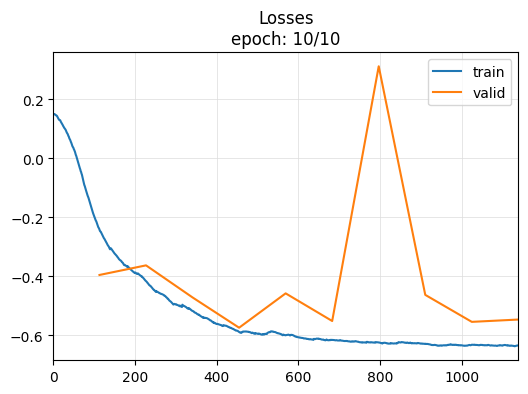

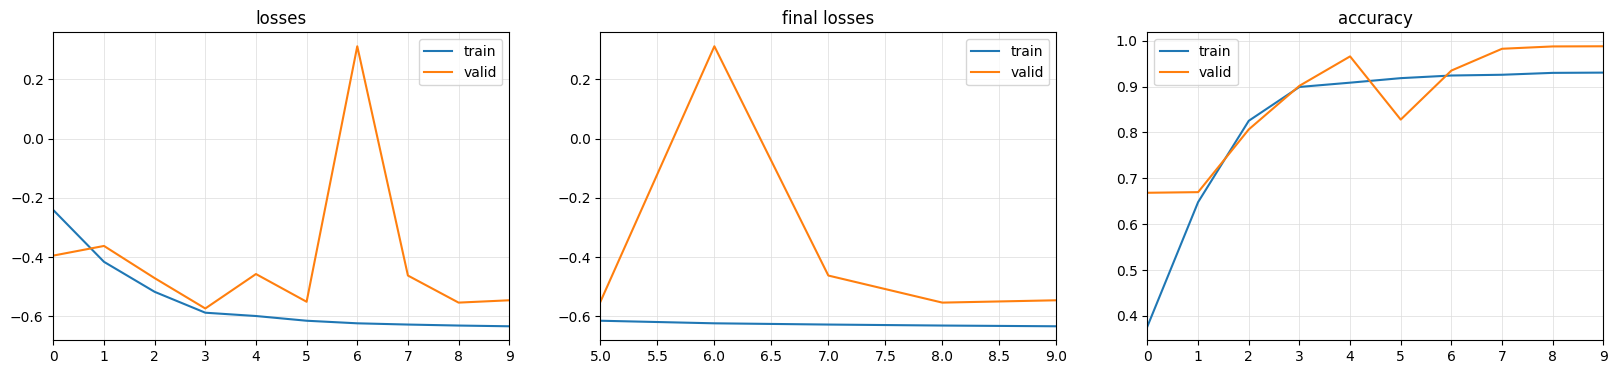

In [181]:
clf.fit_one_cycle(10, 1e-4)

In [182]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
X_all.shape


(10299, 1, 561)

In [184]:
# Train metrics

probas, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = probas.argmax(dim=-1)
print(classification_report(target, preds_train, digits=4))
print(confusion_matrix(target, preds_train))

              precision    recall  f1-score   support

           0     1.0000    0.9256    0.9614      6859
           1     0.4915    1.0000    0.6591       493

    accuracy                         0.9306      7352
   macro avg     0.7458    0.9628    0.8102      7352
weighted avg     0.9659    0.9306    0.9411      7352

[[6349  510]
 [   0  493]]


In [185]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9998    0.9972    0.9985      6366
           1     0.9821    0.9990    0.9904       986

    accuracy                         0.9974      7352
   macro avg     0.9909    0.9981    0.9945      7352
weighted avg     0.9975    0.9974    0.9974      7352

[[6348   18]
 [   1  985]]


In [190]:
# Test metrics

probas, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_test = probas.argmax(dim=-1)
print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9957    0.9273    0.9603      2737
           1     0.5000    0.9476    0.6546       210

    accuracy                         0.9287      2947
   macro avg     0.7478    0.9375    0.8074      2947
weighted avg     0.9604    0.9287    0.9385      2947

[[2538  199]
 [  11  199]]


In [189]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9886    0.9972    0.9929      2527
           1     0.9824    0.9310    0.9560       420

    accuracy                         0.9878      2947
   macro avg     0.9855    0.9641    0.9744      2947
weighted avg     0.9877    0.9878    0.9876      2947

[[2520    7]
 [  29  391]]


In [191]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unmark_pos_tr] == y_train[unmark_pos_tr]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tr)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unmark_pos_tr)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unmark_pos_tst] == y_test[unmark_pos_tst]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tst)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unmark_pos_tst)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 492
In percentage: 0.9980
Test
Total number of positive sampels:420
Total number of unmarked positive sampels: 210
Number of unmarked samples correctly predicted as positive: 192
In percentage: 0.9143


## InceptionTime + CE

In [147]:
from tsai.all import *

#criterion = PULossWrapped(prior=positive_prior, nnPU=True)
criterion = nn.CrossEntropyLoss(weight=ce_weight)

X_all = np.concatenate([X_train_np, X_test_np]).astype(np.float32)
y_all = np.concatenate([y_train_pu, y_test])

splits = (list(range(len(y_train_np))),
          list(range(len(y_train_np), len(y_all))))

tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus",
                   tfms=tfms, batch_tfms=batch_tfms,train_metrics=True, loss_func=criterion,
                   metrics=accuracy, cbs=ShowGraph(), wd=1e-3)


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.539847,0.389391,0.374046,0.790635,00:03
1,0.337360,0.827303,0.198189,0.924330,00:03
2,0.259229,0.903509,0.161670,0.879878,00:03
3,0.205425,0.922286,0.185981,0.808280,00:03
4,0.181141,0.928043,0.116993,0.961995,00:03
5,0.166760,0.932429,0.097818,0.971836,00:03
6,0.151961,0.935033,1.489275,0.858500,00:03
7,0.139827,0.936541,0.160826,0.986427,00:03
8,0.124715,0.938048,0.309817,0.965728,00:03
9,0.121242,0.937226,0.284759,0.968442,00:03


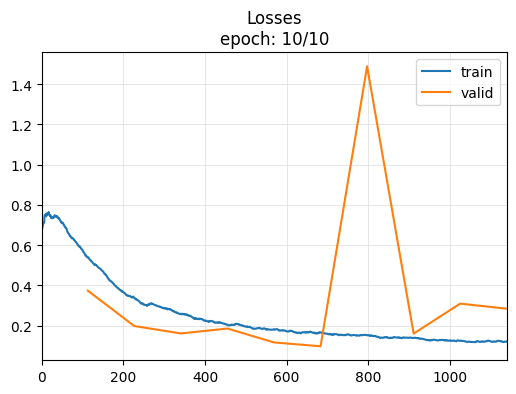

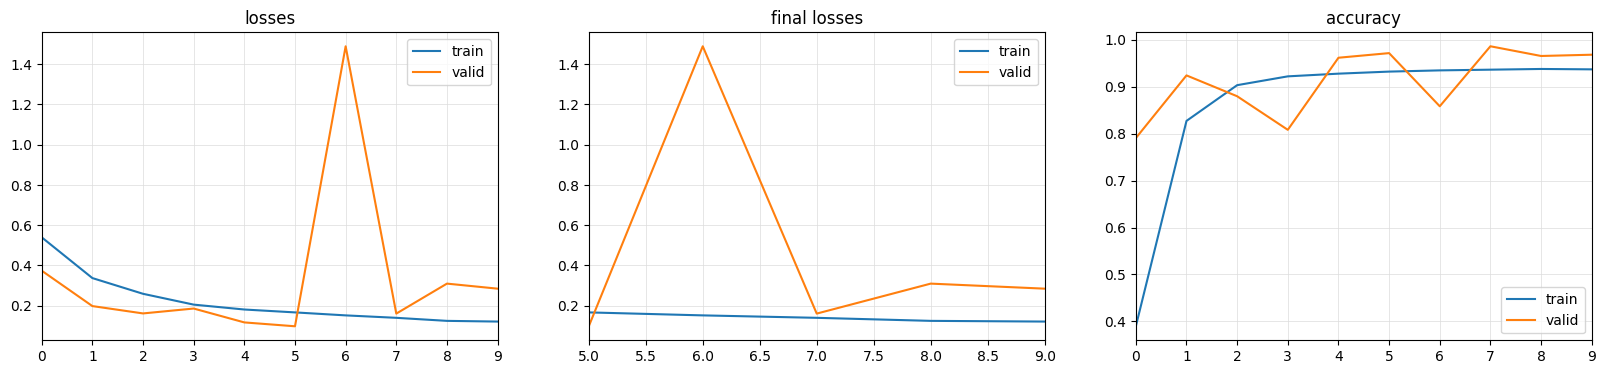

In [148]:
clf.fit_one_cycle(10, 1e-4)

In [149]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
X_all.shape


(10299, 1, 561)

In [150]:
# Train metrics

probas, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = probas.argmax(dim=-1)
print(classification_report(target, preds_train, digits=4))
print(confusion_matrix(target, preds_train))

              precision    recall  f1-score   support

           0     1.0000    0.9331    0.9654      6859
           1     0.5179    1.0000    0.6824       493

    accuracy                         0.9376      7352
   macro avg     0.7589    0.9665    0.8239      7352
weighted avg     0.9677    0.9376    0.9464      7352

[[6400  459]
 [   0  493]]


In [151]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9945    0.9998    0.9972      6366
           1     0.9989    0.9645    0.9814       986

    accuracy                         0.9951      7352
   macro avg     0.9967    0.9822    0.9893      7352
weighted avg     0.9951    0.9951    0.9951      7352

[[6365    1]
 [  35  951]]


In [152]:
# Test metrics

probas, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_test = probas.argmax(dim=-1)
print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9836    0.9415    0.9621      2737
           1     0.5107    0.7952    0.6220       210

    accuracy                         0.9311      2947
   macro avg     0.7471    0.8684    0.7920      2947
weighted avg     0.9499    0.9311    0.9379      2947

[[2577  160]
 [  43  167]]


In [153]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9645    1.0000    0.9819      2527
           1     1.0000    0.7786    0.8755       420

    accuracy                         0.9684      2947
   macro avg     0.9823    0.8893    0.9287      2947
weighted avg     0.9696    0.9684    0.9668      2947

[[2527    0]
 [  93  327]]


In [154]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unmark_pos_tr] == y_train[unmark_pos_tr]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tr)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unmark_pos_tr)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unmark_pos_tst] == y_test[unmark_pos_tst]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tst)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unmark_pos_tst)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 458
In percentage: 0.9290
Test
Total number of positive sampels:420
Total number of unmarked positive sampels: 210
Number of unmarked samples correctly predicted as positive: 160
In percentage: 0.7619


## InceptionTime + PU Loss

In [138]:
from tsai.all import *
from pu_loss import PUAsymLoss_CE

criterion = PULossWrapped(prior=positive_prior, nnPU=True)
#criterion = PUAsymLoss_CE(gamma=0.5)


X_all = np.concatenate([X_train_np, X_test_np]).astype(np.float32)
y_all = np.concatenate([y_train_pu, y_test_pu])

splits = (list(range(len(y_train_np))),
          list(range(len(y_train_np), len(y_all))))

tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus",
                   tfms=tfms, batch_tfms=batch_tfms,train_metrics=True, loss_func=criterion,
                   metrics=accuracy, cbs=ShowGraph(), wd=1e-3)


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.431138,0.932977,0.238659,0.857482,00:03
1,0.227093,0.931058,0.139235,0.898202,00:03
2,0.138639,0.929825,0.162354,0.857482,00:03
3,0.113171,0.931195,0.086407,0.863929,00:03
4,0.083469,0.939145,0.195814,0.857482,00:03
5,0.081083,0.936678,0.140543,0.857482,00:03
6,0.060266,0.940515,0.037225,0.959959,00:03
7,0.053822,0.941749,0.036959,0.929759,00:03
8,0.052117,0.945998,0.032355,0.906006,00:03
9,0.054530,0.948054,0.032438,0.915168,00:03


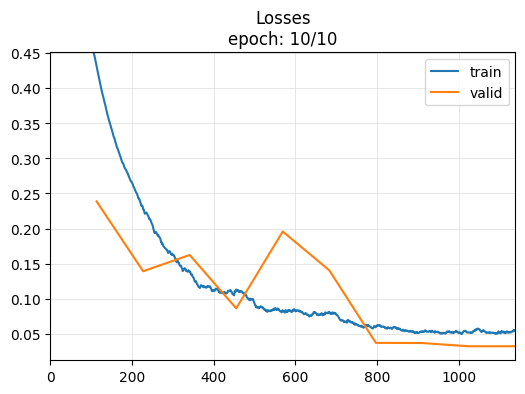

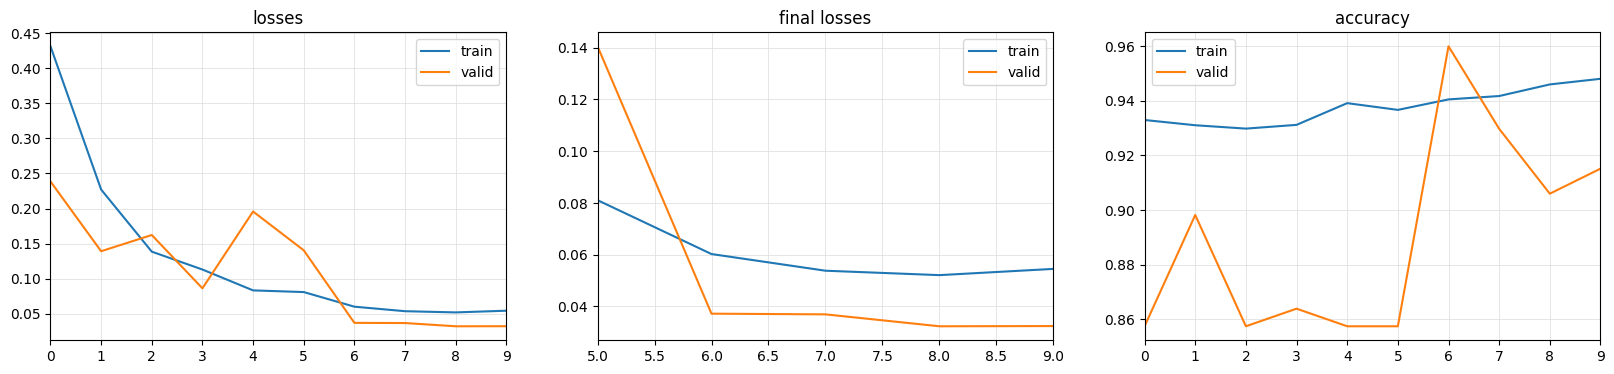

In [139]:
clf.fit_one_cycle(10, 1e-4)

In [140]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
X_all.shape


(10299, 1, 561)

In [141]:
# Train metrics

probas, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = probas.argmax(dim=-1)
print(classification_report(target, preds_train, digits=4))
print(confusion_matrix(target, preds_train))

              precision    recall  f1-score   support

           0     0.9859    0.9564    0.9709      6859
           1     0.5716    0.8093    0.6700       493

    accuracy                         0.9465      7352
   macro avg     0.7788    0.8829    0.8205      7352
weighted avg     0.9581    0.9465    0.9507      7352

[[6560  299]
 [  94  399]]


In [142]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9567    1.0000    0.9779      6366
           1     1.0000    0.7079    0.8290       986

    accuracy                         0.9608      7352
   macro avg     0.9784    0.8540    0.9034      7352
weighted avg     0.9625    0.9608    0.9579      7352

[[6366    0]
 [ 288  698]]


In [145]:
# Test metrics

probas, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_test = probas.argmax(dim=-1)
print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9557    0.9697    0.9626      2737
           1     0.5118    0.4143    0.4579       210

    accuracy                         0.9301      2947
   macro avg     0.7337    0.6920    0.7103      2947
weighted avg     0.9241    0.9301    0.9267      2947

[[2654   83]
 [ 123   87]]


In [144]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9100    1.0000    0.9529      2527
           1     1.0000    0.4048    0.5763       420

    accuracy                         0.9152      2947
   macro avg     0.9550    0.7024    0.7646      2947
weighted avg     0.9228    0.9152    0.8992      2947

[[2527    0]
 [ 250  170]]


In [146]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unmark_pos_tr] == y_train[unmark_pos_tr]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tr)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unmark_pos_tr)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unmark_pos_tst] == y_test[unmark_pos_tst]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tst)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unmark_pos_tst)):.4f}")

Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 299
In percentage: 0.6065
Test
Total number of positive sampels:420
Total number of unmarked positive sampels: 210
Number of unmarked samples correctly predicted as positive: 83
In percentage: 0.3952
